In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

2024-03-04 14:33:16.519422: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Baseline Model Metrics

In [2]:
folder = 'pickle'
inner_folder = 'model'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

2024-03-04 14:33:18.160739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 14:33:18.171745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 14:33:18.172034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

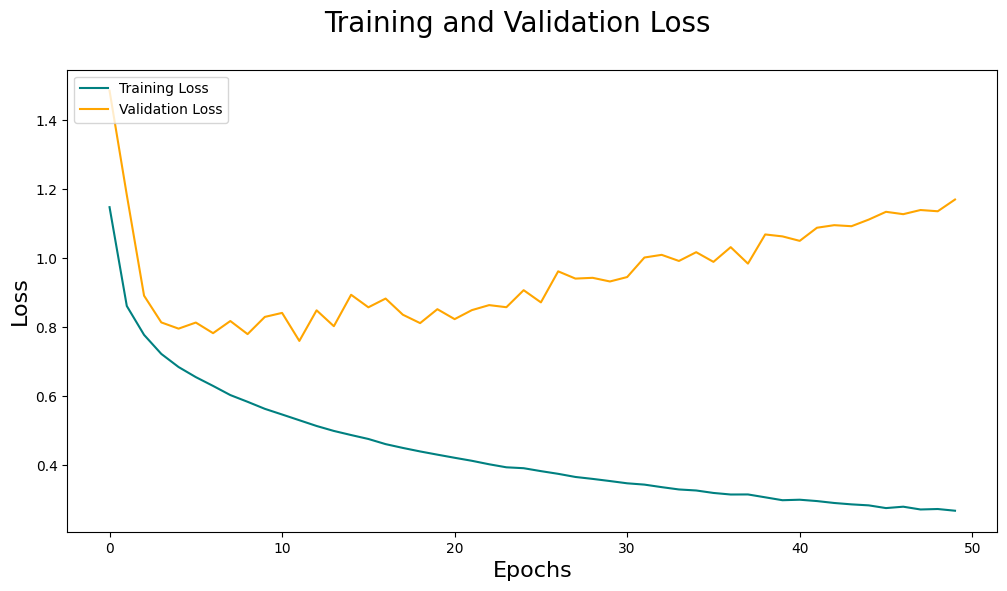

In [3]:
fig = plt.figure()
plt.plot(loaded_history['loss'], color='teal', label='Training Loss')
plt.plot(loaded_history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Training and Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

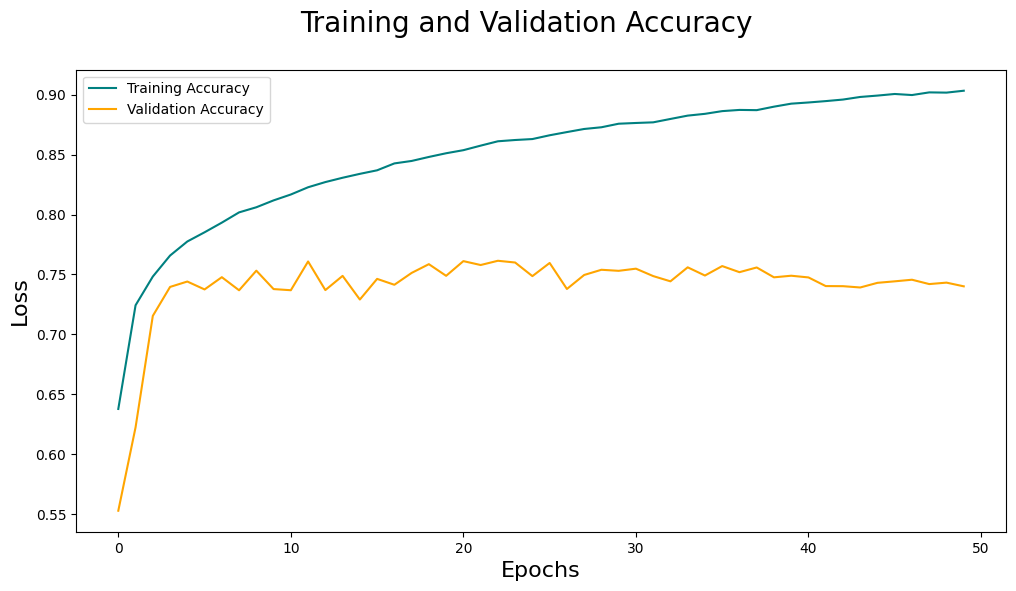

In [4]:
fig = plt.figure()
plt.plot(loaded_history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training and Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

In [6]:
pre = Precision()
re = Recall()
acc = Accuracy()

precision_per_class = [tf.keras.metrics.Precision(class_id=i) for i in range(21)]
recall_per_class = [tf.keras.metrics.Recall(class_id=i) for i in range(21)]
accuracy_per_class = [tf.keras.metrics.BinaryAccuracy(threshold=0.0) for _ in range(21)]

In [7]:
val_data = tf.keras.utils.image_dataset_from_directory('Validation', image_size=(250, 250))
val_data = val_data.map(lambda image,label: (image/255, label))

y_true = []
y_pred = []

for batch in val_data.as_numpy_iterator():
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image, verbose=0)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))

Found 23973 files belonging to 21 classes.


2024-03-04 14:33:58.733628: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [23973]
	 [[{{node Placeholder/_4}}]]
2024-03-04 14:33:58.734059: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [23973]
	 [[{{node Placeholder/_4}}]]


In [8]:
print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_labels = [str(i) for i in range(21)]
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]


# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.7629545331001282, Recall:0.724731981754303, Accuracy:0.03145602345466614
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.72      0.83      0.77      2747
         BAS       0.25      0.10      0.14        61
         BLA       0.59      0.71      0.64      1675
         EBO       0.88      0.91      0.90      3834
         EOS       0.87      0.85      0.86       822
         FGC       0.00      0.00      0.00         6
         HAC       0.29      0.21      0.24        57
         KSC       0.00      0.00      0.00         6
         LYI       0.00      0.00      0.00         9
         LYT       0.82      0.82      0.82      3673
         MMZ       0.24      0.21      0.22       427
         MON       0.41      0.42      0.41       564
         MYB       0.51      0.39      0.44       917
         NGB       0.54      0.57      0.55      1394
         NGS       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


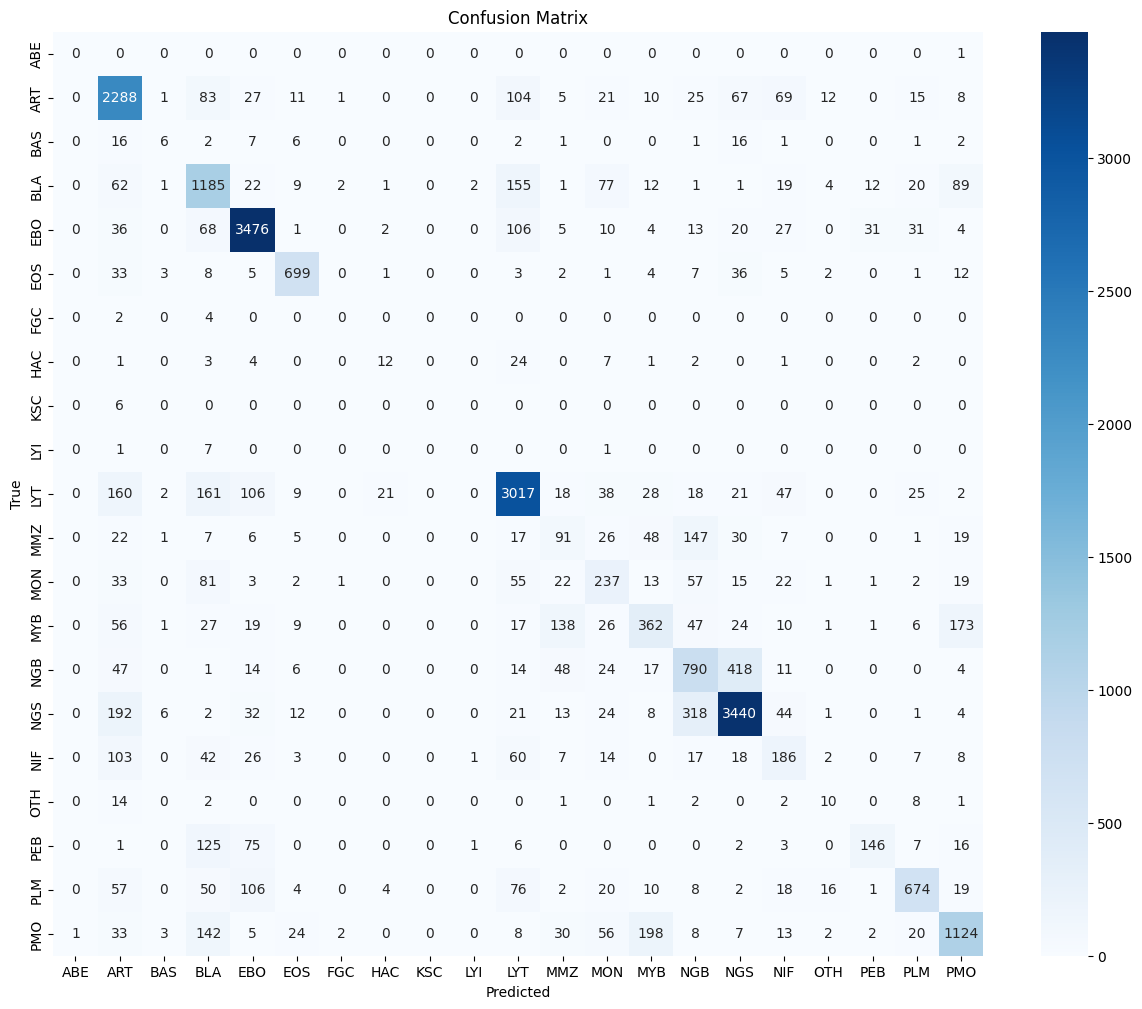

In [9]:
true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

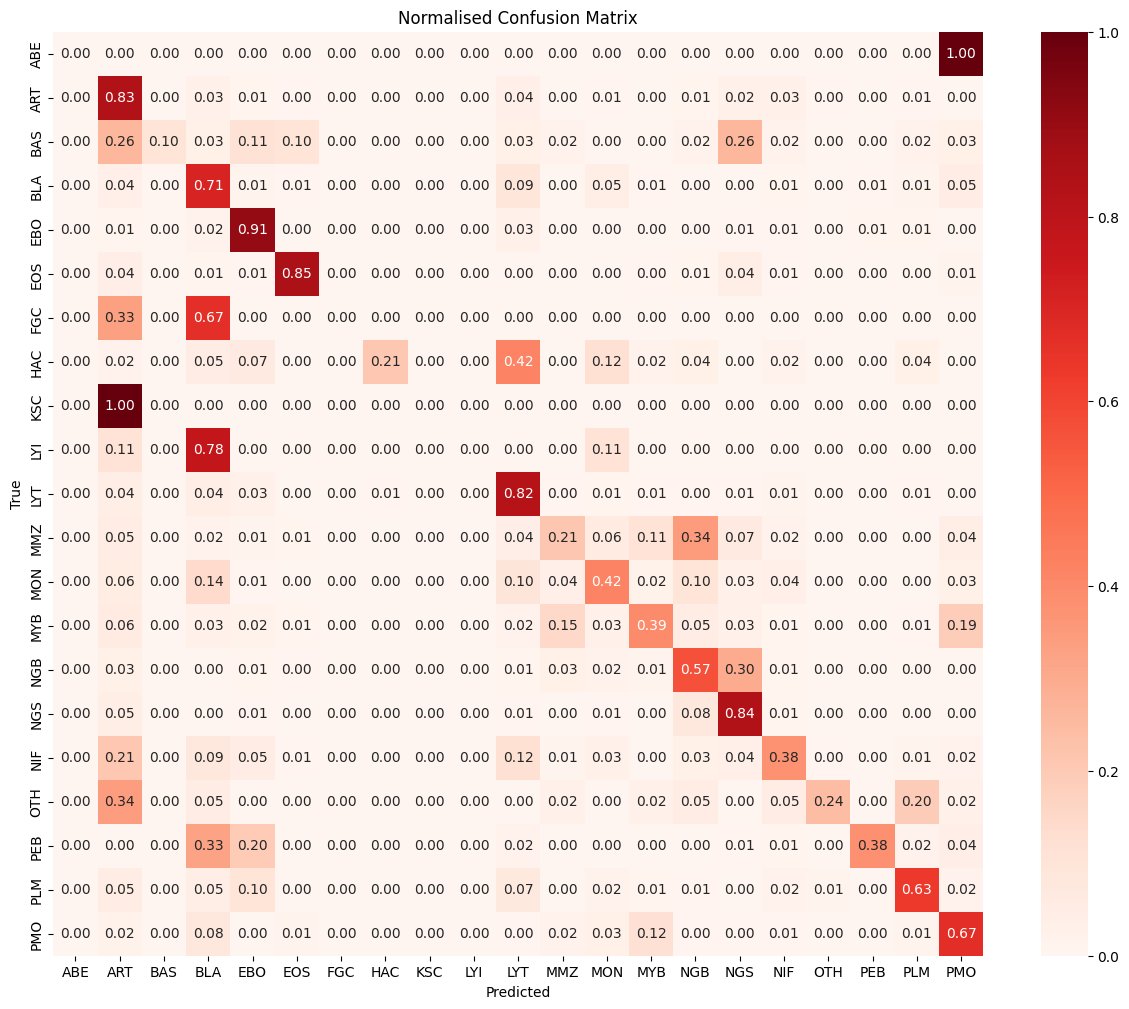

In [10]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i]

plt.figure(figsize=(15, 12))
sns.heatmap(normalised_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [13]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder, 'confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)

# Optimised Model Metrics

In [14]:
folder = 'pickle'
inner_folder = 'optimised'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

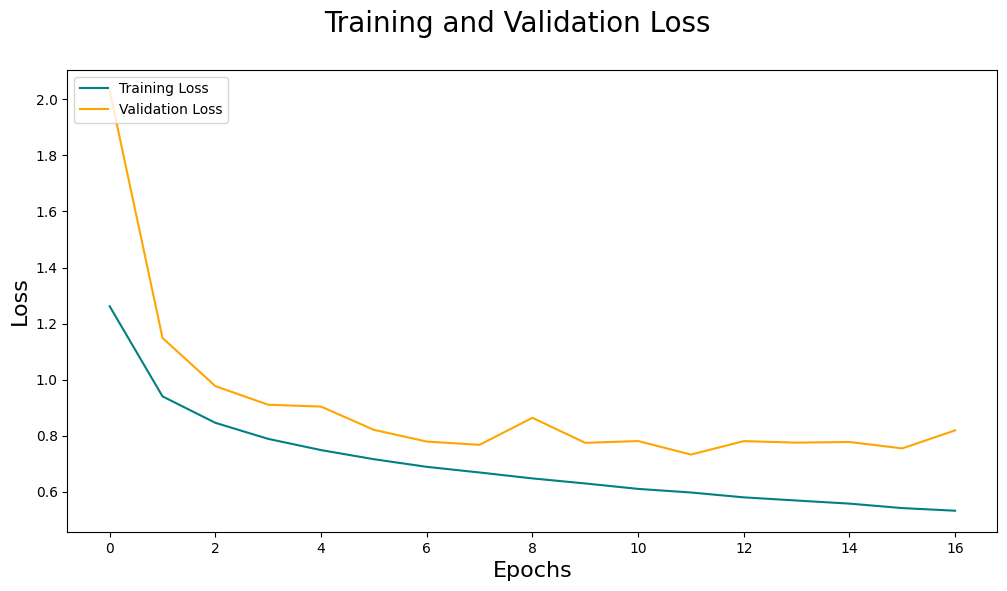

In [15]:
fig = plt.figure()
plt.plot(loaded_history['loss'], color='teal', label='Training Loss')
plt.plot(loaded_history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Training and Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

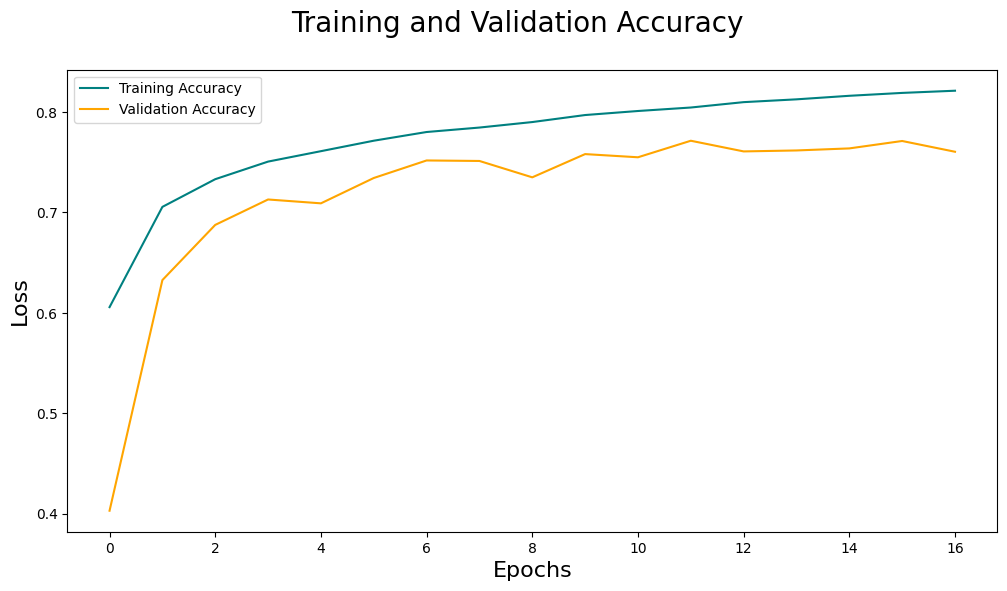

In [16]:
fig = plt.figure()
plt.plot(loaded_history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training and Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

In [17]:
y_true = []
y_pred = []

for batch in val_data.as_numpy_iterator():
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image, verbose=0)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))

In [18]:
print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.7837003469467163, Recall:0.7252325415611267, Accuracy:0.017575327306985855
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.72      0.86      0.78      2747
         BAS       0.00      0.00      0.00        61
         BLA       0.68      0.61      0.65      1675
         EBO       0.89      0.90      0.90      3834
         EOS       0.95      0.74      0.84       822
         FGC       0.00      0.00      0.00         6
         HAC       0.50      0.07      0.12        57
         KSC       0.00      0.00      0.00         6
         LYI       0.00      0.00      0.00         9
         LYT       0.82      0.87      0.84      3673
         MMZ       0.30      0.15      0.20       427
         MON       0.54      0.47      0.50       564
         MYB       0.62      0.32      0.42       917
         NGB       0.52      0.70      0.60      1394
         NGS       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


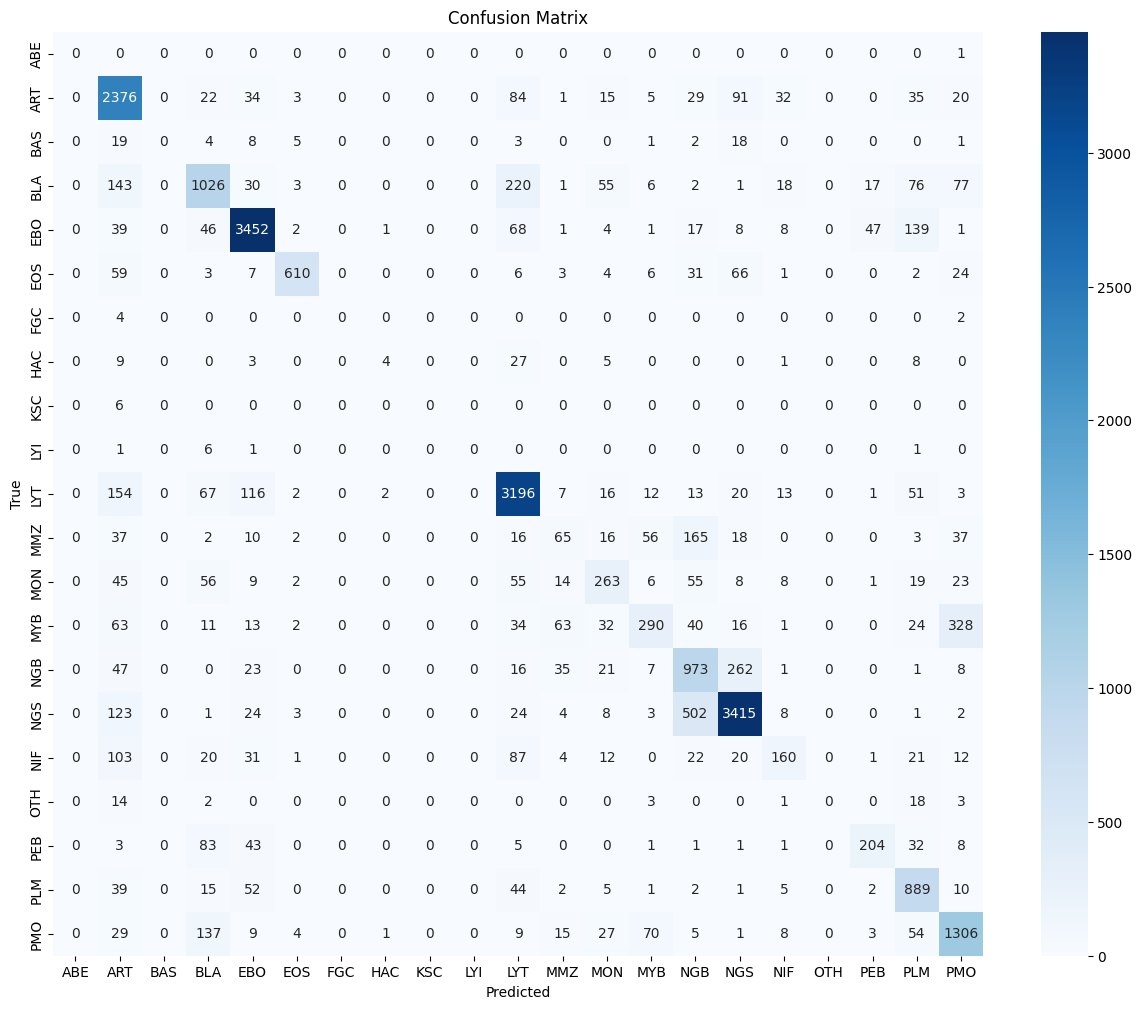

In [19]:
true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

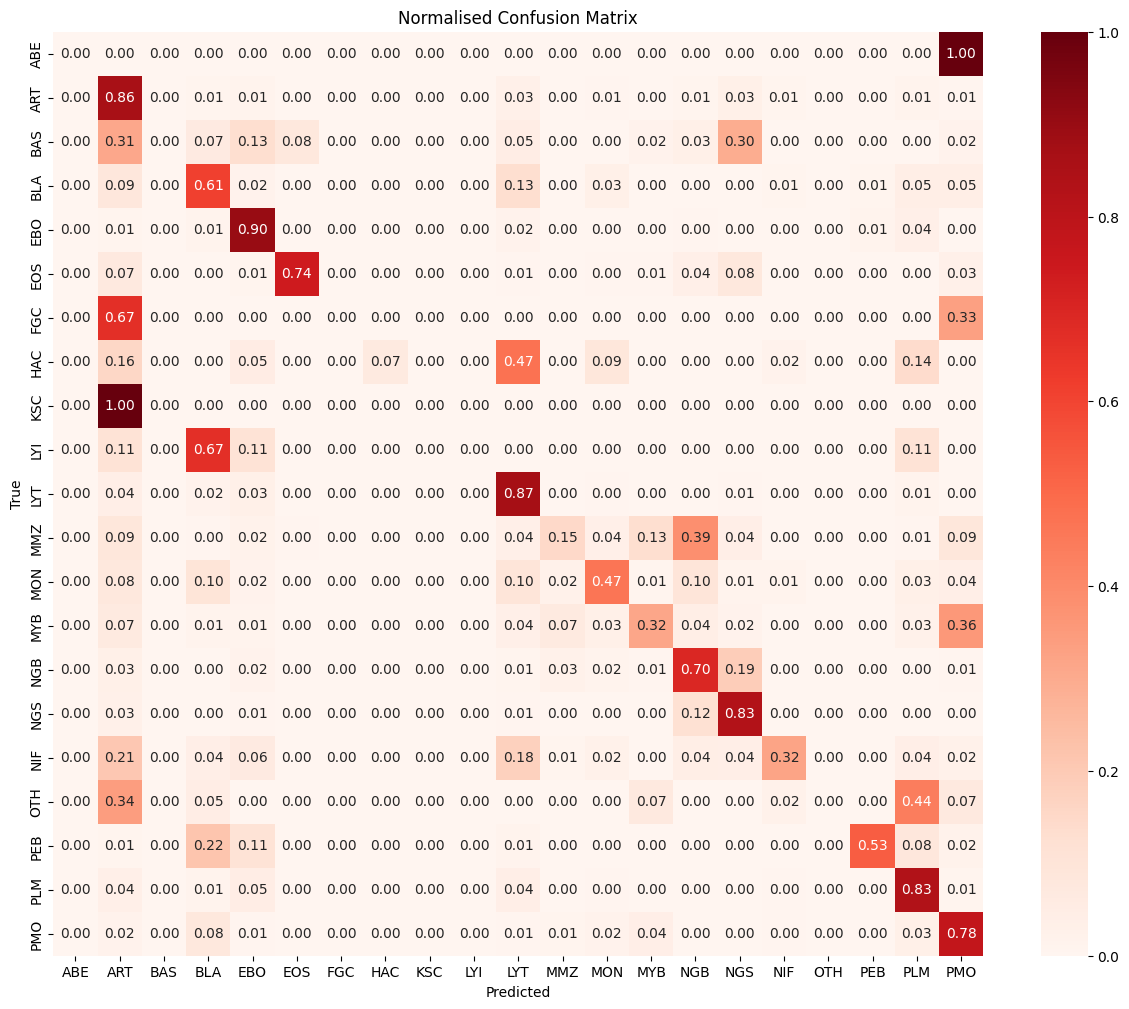

In [20]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i]

plt.figure(figsize=(15, 12))
sns.heatmap(normalised_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [21]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder,  'confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)

In [22]:
folder = 'pickle'
inner_folder = 'augmented_2'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

# Optimised Model (With Data Augmentation) Metrics

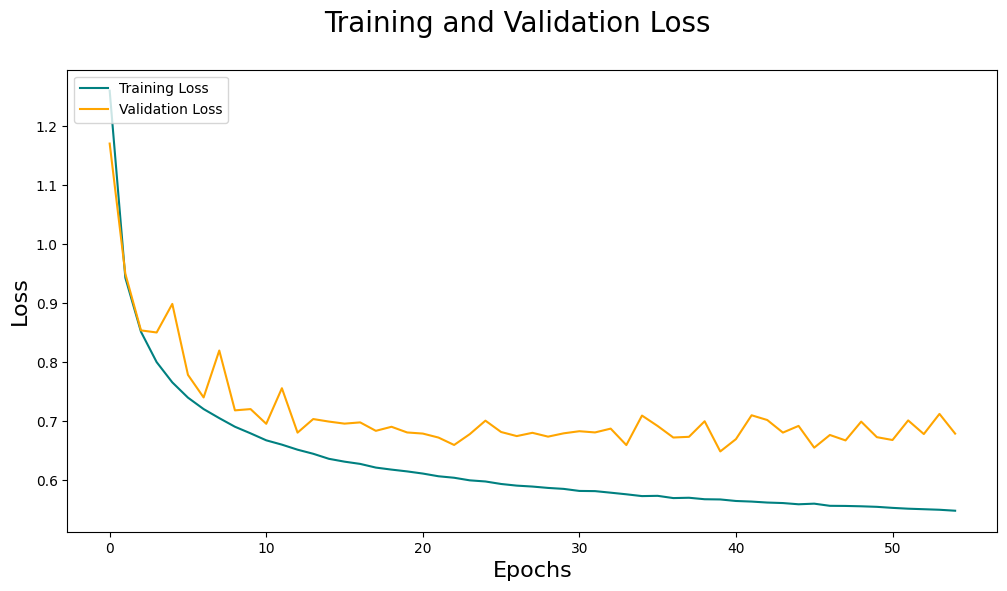

In [23]:
fig = plt.figure()
plt.plot(loaded_history['loss'], color='teal', label='Training Loss')
plt.plot(loaded_history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Training and Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

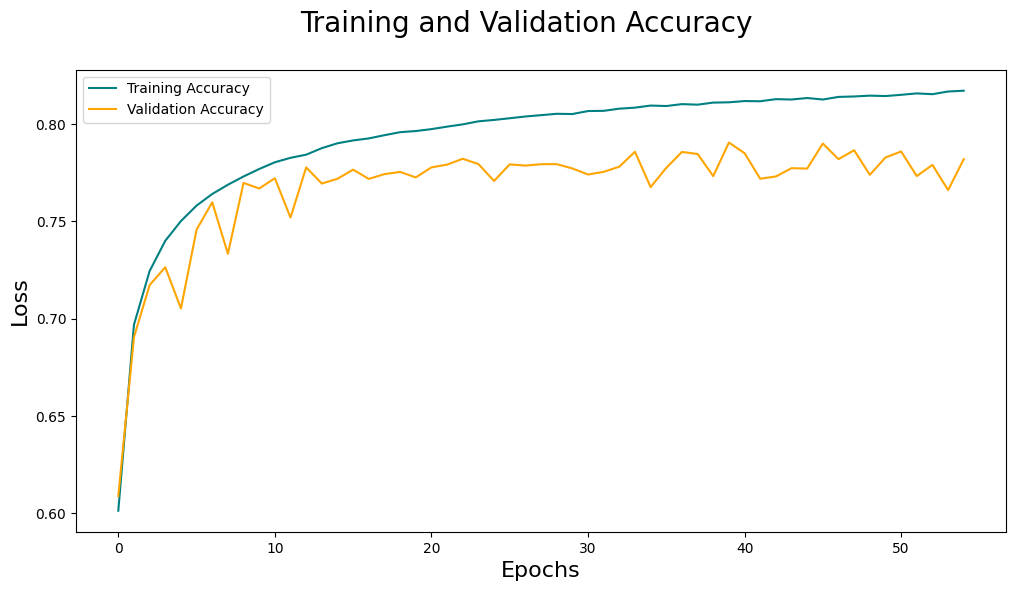

In [24]:
fig = plt.figure()
plt.plot(loaded_history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training and Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

In [25]:
y_true = []
y_pred = []

for batch in val_data.as_numpy_iterator():
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image, verbose=0)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))

In [26]:
print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)


class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.7978928685188293, Recall:0.730794370174408, Accuracy:0.01758194901049137
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.86      0.78      0.82      2747
         BAS       0.20      0.61      0.30        61
         BLA       0.75      0.70      0.72      1675
         EBO       0.88      0.92      0.90      3834
         EOS       0.88      0.93      0.90       822
         FGC       0.14      0.50      0.21         6
         HAC       0.29      0.58      0.39        57
         KSC       0.13      0.33      0.19         6
         LYI       0.05      0.11      0.07         9
         LYT       0.87      0.84      0.86      3673
         MMZ       0.34      0.51      0.41       427
         MON       0.49      0.67      0.57       564
         MYB       0.59      0.56      0.58       917
         NGB       0.58      0.66      0.61      1394
         NGS       0.

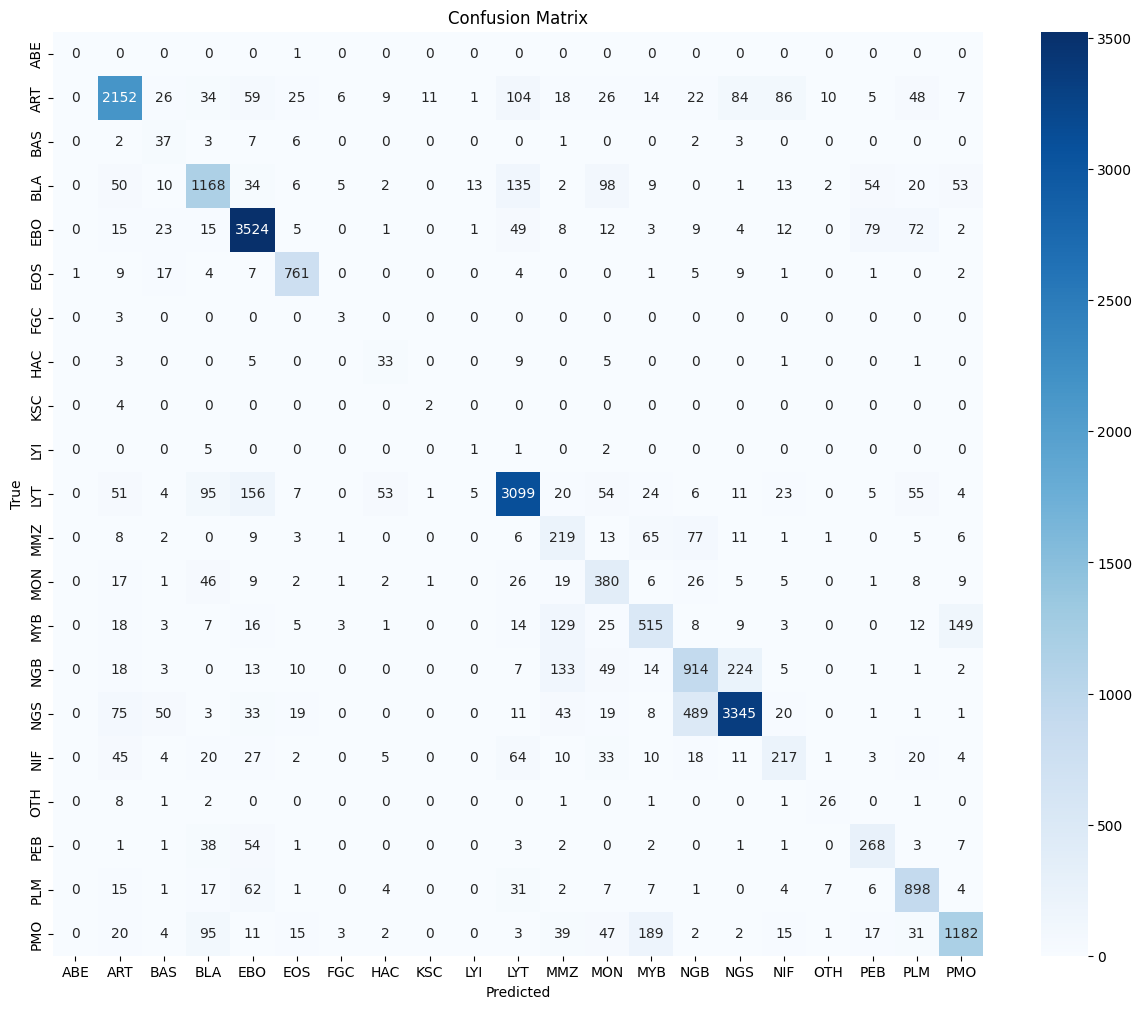

In [27]:
true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

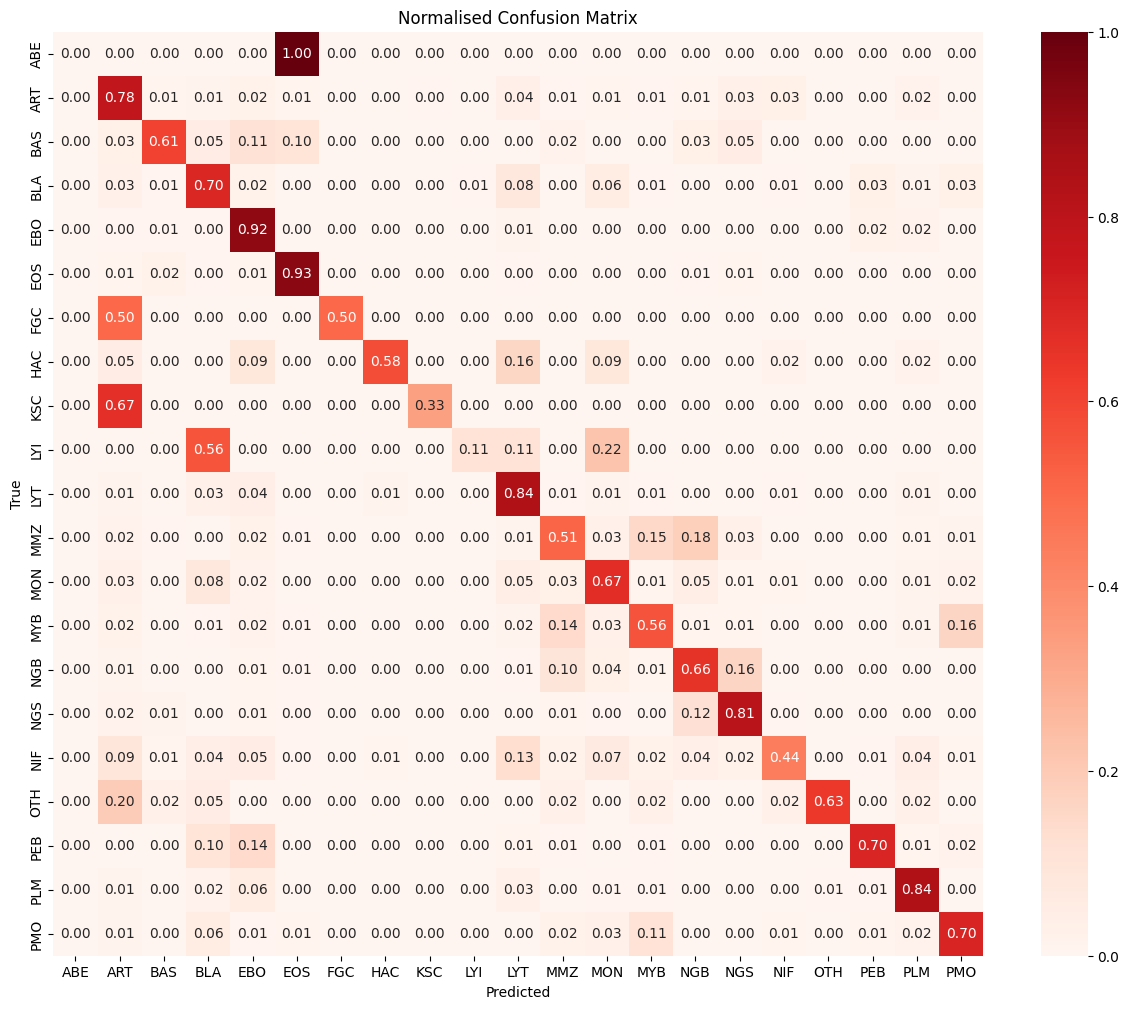

In [28]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i]

plt.figure(figsize=(15, 12))
sns.heatmap(normalised_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [29]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder,  'confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)